Cargamos la información provista para el TP

In [1]:
load("TP4.Rdata", verbose = TRUE)

Loading objects:
  esp_train
  RRL
  esp_test
  diag_test
  .Random.seed
  diag_train


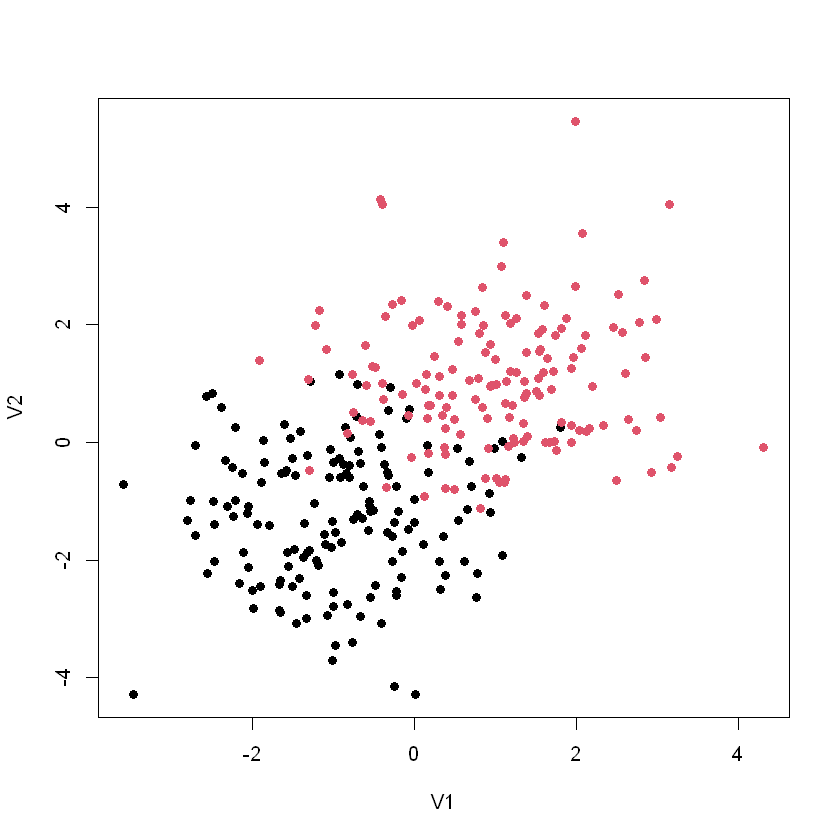

In [2]:
plot(diag_train[,-3], col = diag_train[,3], pch = 20, cex = 1.5)

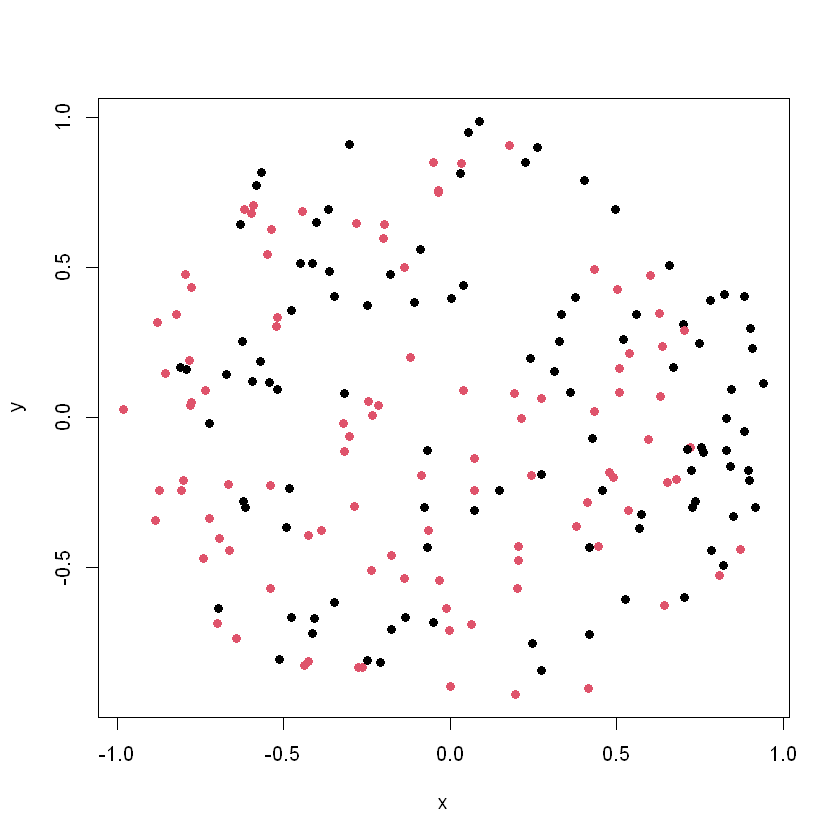

In [3]:
plot(esp_train[,-3], col=esp_train[,3], pch=20, cex=1.5)

In [4]:
install.packages("robustbase")

: 

: 

In [ ]:
install.packages("caret")

In [2]:
# install.packages("adabag")
library("adabag")

Warning message:
"package 'adabag' was built under R version 4.2.2"
Loading required package: rpart

Loading required package: caret

Warning message:
"package 'caret' was built under R version 4.2.2"
Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.2.2"
Loading required package: lattice

Loading required package: foreach

Warning message:
"package 'foreach' was built under R version 4.2.2"
Loading required package: doParallel

Warning message:
"package 'doParallel' was built under R version 4.2.2"
Loading required package: iterators

Warning message:
"package 'iterators' was built under R version 4.2.2"
Loading required package: parallel



In [5]:
data("iris")
train <- c(sample(1:50, 25), sample(51:100, 25), sample(101:150, 25))
iris.adaboost <- boosting(Species ~ ., data = iris[train, ], mfinal = 10, coef="Freund", control = rpart.control(maxdepth =
3))


Hacemos 20 arboles, que varian en profundidad de 1 a 20. Cada ensemble tiene 200 arboles.

In [20]:
pred_esp_test <- double(20)
pred_diag_test <- double(20)

for( i in 1:20){
  esp.adaboost <- boosting(class ~ ., data = esp_train, mfinal = 200, coef="Freund", control = rpart.control(maxdepth =
i))
  pred_esp_test[i] <- predict(esp.adaboost, newdata = esp_test, type = "class")$error
  
  diag.adaboost <- boosting(class ~ ., data = diag_train, mfinal = 200, coef="Freund", control = rpart.control(maxdepth =
i))
  pred_diag_test[i] <- predict(diag.adaboost, newdata = diag_test, type = "class")$error
}

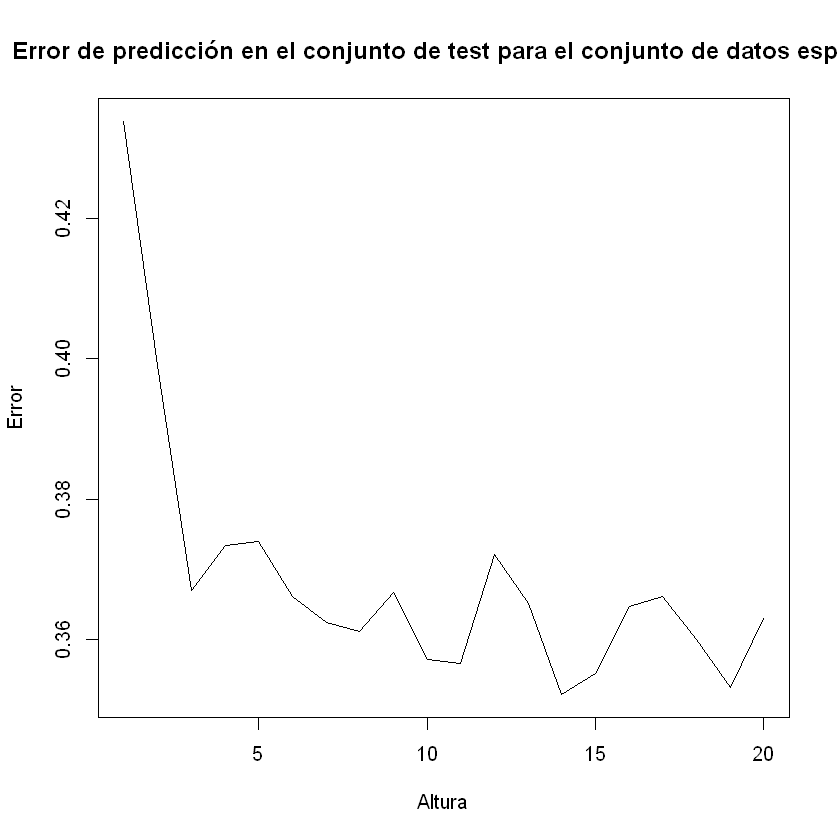

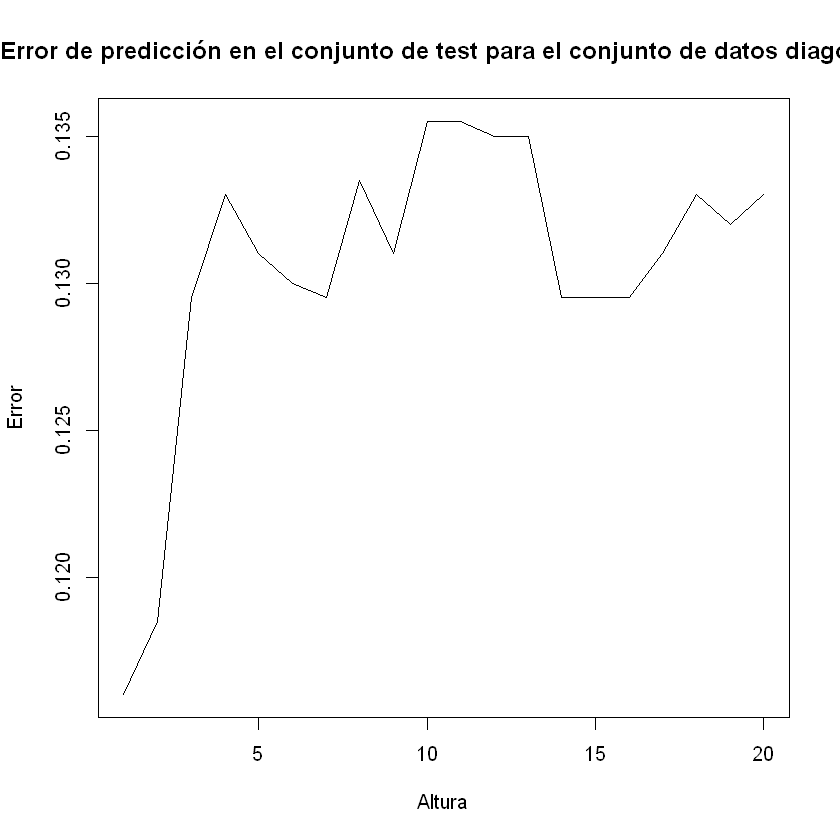

In [23]:
plot(1:20,pred_esp_test[1:20], type = "l", xlab="Altura", ylab="Error", main="Error de predicción en el conjunto de test para el conjunto de datos espiral")
plot(1:20,pred_diag_test[1:20], type = "l", xlab="Altura", ylab="Error", main="Error de predicción en el conjunto de test para el conjunto de datos diagonal")

Podemos ver que, en el caso del dataset espiral, el error disminuye considerablemente para árboles de profundidad 5. Luego existen altibajos, pero se mantienen dentro de un margen estable y parece que tienden a bajar si aumentáramos la profundidad.

Me sorprendió el caso del dataset diagonal, donde el error aumenta a partir de los 5 árboles. Creo que esto se debe a que el dataset es muy simple y no tiene mucho sentido hacer árboles de profundidad mayor a 5.

Vamos a analizar ahora el dataset RRL

In [24]:
summary(RRL)

   Amplitude       AndersonDarling  Autocor_length    Beyond1Std      
 Min.   :0.01550   Min.   :0.1237   Min.   :1.000   Min.   :0.007143  
 1st Qu.:0.09469   1st Qu.:0.9474   1st Qu.:1.000   1st Qu.:0.228361  
 Median :0.14950   Median :1.0000   Median :1.000   Median :0.271930  
 Mean   :0.15444   Mean   :0.9109   Mean   :1.252   Mean   :0.258909  
 3rd Qu.:0.19300   3rd Qu.:1.0000   3rd Qu.:1.000   3rd Qu.:0.307295  
 Max.   :1.57950   Max.   :1.0000   Max.   :7.000   Max.   :0.638060  
    CAR_mean          CAR_sigma            CAR_tau             Con           
 Min.   :     0.0   Min.   :-57.33259   Min.   :      0   Min.   :0.0000000  
 1st Qu.:    24.0   1st Qu.: -0.16407   1st Qu.:      0   1st Qu.:0.0000000  
 Median :    27.5   Median :  0.00000   Median :      1   Median :0.0000000  
 Mean   :  9695.5   Mean   :  0.45900   Mean   :   7144   Mean   :0.0004529  
 3rd Qu.:   149.2   3rd Qu.:  0.00459   3rd Qu.:      1   3rd Qu.:0.0000000  
 Max.   :773430.0   Max.   :208.874

La variable a predecir es Tipo. Vamos a usar Random Forest y variar la cantidad de features evaluadas en cada caso.

In [3]:
# install.packages("randomForest")
library("randomForest")

Warning message:
"package 'randomForest' was built under R version 4.2.2"
randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin




In [19]:
cant.vars <- c(69, 34, 17, 8, 4, 2, 1) #Cantidad de variables a usar en cada paso, dada en el enunciado
errors_rf <- double(7) #Lista de errores

for (k in 1:7){
    error_k <- double(50) #Vector de errores para el k actual
    for(i in 1:5){
        rf <- randomForest(Tipo ~ . , data = RRL, mtry = cant.vars[k], ntree = 1000) #1000 es el número mágico de árboles
        miss <- rf$confusion[1,2] + rf$confusion[2,1] #Cantidad de errores
        error_k[i] <- miss/7060 #Error de predicción en el intento i
    }
    errors_rf[k] <- mean(error_k) #Guardo los errores para el k actual
}

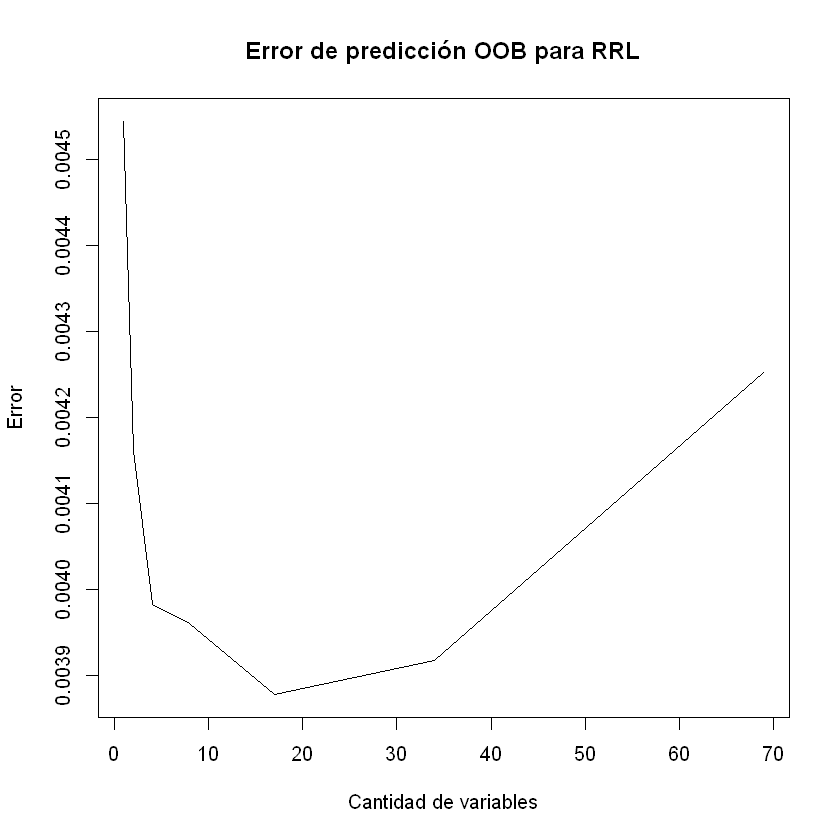

In [20]:
plot(cant.vars,errors_rf, type = "l", xlab="Cantidad de variables", ylab="Error", main="Error de predicción OOB para RRL")

Partimos de la base que el error ya es pequeño (menos del 5%). Se puede observar que el error disminuye rápidamente hasta las 17 variables utilizadas, y luego comienza a aumentar. Según las optimizaciones vistas en teoría, el valor default de mtry debería ser 8 o 9 (sqrt(69) = 8.31). Al aumentar la cantidad de variables, estamos recuperando bagging y aumentando el error, lo cual concuerda con lo visto que Random Forest es una mejora sobre bagging.

Vemos que en 8 variables el error ya es bastante bajo. Por lo tanto, podemos concluir que el valor por defecto de mtry es adecuado para este dataset.

[1] 7060   70